In [2]:
import netCDF4 as nc
import numpy as np
import iris.coords as coords
import cf_units
import iris.cube as icube
import random
import matplotlib.pyplot as plt
import math
import numpy.ma as ma
import datetime as dt
import iris.plot as iplt
import matplotlib as mpl
import iris
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import genextreme as gev


In [3]:
# import functions from FidelityTest.py
from FidelityTest import calcDistrStatistic, timeseries_fid_test, plot_fidelity_testing, get_cube_limits, plotStatsMeasures 


## Alternative load data into Iris cubes

In [6]:
dp3_file_path = '/home/h06/jdavie/ClimateSecurity/Data for Yiwei/Hunan_summer_tas_model_DePreSys3.nc'
obs_file_path = '/home/h06/jdavie/ClimateSecurity/Data for Yiwei/Hunan_summer_tas_obs_ERA5-Land.nc'

alt_obs = iris.load_cube(obs_file_path)
alt_mod = iris.load_cube(dp3_file_path)

print(alt_obs)
print(alt_mod)

2 metre temperature / (celsius)     (time: 30)
    Dimension coordinates:
        time                             x
    Auxiliary coordinates:
        month                            x
        month_number                     x
        season_year                      x
        year                             x
    Scalar coordinates:
        expver                      1
        latitude                    35.000015 degrees, bound=(15.000011, 55.000015) degrees
        longitude                   105.0 degrees, bound=(70.0, 140.0) degrees
    Cell methods:
        0                           year: mean
        1                           longitude: latitude: mean
    Attributes:
        Conventions                 'CF-1.7'
        history                     '2024-05-27 10:04:46 GMT by grib_to_netcdf-2.28.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf ...'
        minimum_weighting           1e-05
air_temperature / (celsius)         (DePreSys start date: 2; time: 30; realization: 40)

## 1. load data to iris cube 
* 1) reshape simulations from 3d to 2d
* 2) convert data to iris cube : mod and obs

In [7]:
# load model data
file_path1 = '/home/h06/jdavie/ClimateSecurity/Data for Yiwei/Hunan_summer_tas_model_DePreSys3.nc'  
sim = nc.Dataset(file_path1, mode='r')


In [46]:
# Testing reshaping

a = np.arange(300).reshape((2, 10, 15))
print(a)

b = a.reshape(10, -1)

c = np.transpose(a, (1, 0, 2))

d = c.reshape(10, -1)
print(d)

[[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14]
  [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29]
  [ 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44]
  [ 45  46  47  48  49  50  51  52  53  54  55  56  57  58  59]
  [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74]
  [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89]
  [ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104]
  [105 106 107 108 109 110 111 112 113 114 115 116 117 118 119]
  [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134]
  [135 136 137 138 139 140 141 142 143 144 145 146 147 148 149]]

 [[150 151 152 153 154 155 156 157 158 159 160 161 162 163 164]
  [165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
  [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194]
  [195 196 197 198 199 200 201 202 203 204 205 206 207 208 209]
  [210 211 212 213 214 215 216 217 218 219 220 221 222 223 224]
  [225 226 227 228 229 230 231 232 233

In [47]:
# obtain air_temperature data 
air_temperature = sim.variables['air_temperature'][:]

# reshape air_temperature from 3d to 2d to do test later
n_years = air_temperature.shape[1]  
n_months = air_temperature.shape[2]

model = air_temperature[:].reshape(n_years, -1)

new_model = np.transpose(air_temperature[:], (1, 0, 2))
new_model = new_model.reshape(n_years, -1)

# check shape
print("air_temperature reshape:", model.shape)


(2, 30, 40)
(2, 30, 40)
air_temperature reshape: (30, 80)


In [10]:
# load observartion temperature data
file_path = '/home/h06/jdavie/ClimateSecurity/Data for Yiwei/Hunan_summer_tas_obs_ERA5-Land.nc'  
observations = nc.Dataset(file_path, mode='r')
t2m = observations.variables['t2m'][:]
print("Shape of t2m:", t2m.shape)
# Convert to numpy array
obs_array = np.array(t2m)

Shape of t2m: (30,)


In [11]:
# create obs cube
time_coord = coords.DimCoord(range(t2m.shape[0]), standard_name='time')
if obs_array.ndim > 1:
    year_coord = coords.DimCoord(range(t2m.shape[1]), standard_name='year')
    # define units for each coord
    year_coord.units = cf_units.Unit('years since 1993', calendar='gregorian')
    # cube
    cube = iris.cube.Cube(t2m, dim_coords_and_dims=[(time_coord, 0), (year_coord, 1)])
else:
    obs = iris.cube.Cube(t2m, dim_coords_and_dims=[(time_coord, 0)])
obs.long_name = 'Hunan January Temperature (ERA5-Land)'
obs.units = 'celsius'
obs

Hunan January Temperature (Era5-Land) (celsius),time
Shape,30
Dimension coordinates,
time,x


In [49]:
# create model cube
time_coord = coords.DimCoord(range(model.shape[0]), standard_name='time')
if model.ndim > 1:
    year_coord = coords.DimCoord(range(model.shape[1]), standard_name='realization')
    year_coord.units = cf_units.Unit('years since 1993', calendar='gregorian')
    mod = iris.cube.Cube(model, dim_coords_and_dims=[(time_coord, 0), (year_coord, 1)])
else:
    mod = iris.cube.Cube(model, dim_coords_and_dims=[(time_coord, 0)])
mod.long_name = 'Hunan_Jan_tas_model_DePreSys3'
mod.units = 'celsius'
print(mod)


# create new model cube
time_coord = coords.DimCoord(range(new_model.shape[0]), standard_name='time')
if new_model.ndim > 1:
    year_coord = coords.DimCoord(range(new_model.shape[1]), standard_name='realization')
    year_coord.units = cf_units.Unit('years since 1993', calendar='gregorian')
    new_mod = iris.cube.Cube(new_model, dim_coords_and_dims=[(time_coord, 0), (year_coord, 1)])
else:
    new_mod = iris.cube.Cube(new_model, dim_coords_and_dims=[(time_coord, 0)])
new_mod.long_name = 'Hunan_Jan_tas_model_DePreSys3'
new_mod.units = 'celsius'
print(new_mod)

Hunan_Jan_tas_model_DePreSys3 / (celsius) (time: 30; realization: 80)
    Dimension coordinates:
        time                                   x                -
        realization                            -                x
Hunan_Jan_tas_model_DePreSys3 / (celsius) (time: 30; realization: 80)
    Dimension coordinates:
        time                                   x                -
        realization                            -                x


[26.41057359 25.26718307 25.92040471 24.80214677 25.49214547 24.65696853
 25.34748528 25.77216755 26.68836132 25.95505949 25.96938575 26.6699903
 25.23973835 25.98271369 25.42338353 26.30345382 25.13081214 26.34889037
 25.67923297 26.56085859 26.67511547 25.8723704  25.19898539 25.87469551
 25.51729334 26.99279864 25.21582205 25.53544679 26.31474584 25.30992781
 26.45737807 26.69131945 26.87787218 26.56633714 25.32374841 25.88051264
 26.03220609 27.43811815 25.81362139 27.08983834 25.80758083 26.22792417
 25.91469014 26.75053996 26.55278796 26.60993414 24.96133132 26.23752925
 26.02519753 25.90818322 25.35115622 26.06402788 25.61578567 26.38171814
 25.78143923 25.88253358 26.49736669 26.5194408  25.95788157 26.65747134
 26.14049807 26.73064255 27.0493819  25.78289844 26.46124465 25.74273436
 26.17864617 26.38422418 26.43711434 26.37545073 25.65850096 25.33057409
 26.68640147 26.48495518 25.81479617 25.18950272 26.29160119 25.65224853
 26.6671543  26.53922965]
[26.41057359 25.26718307 2

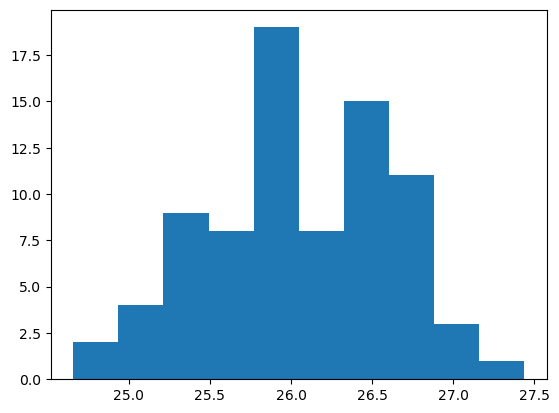

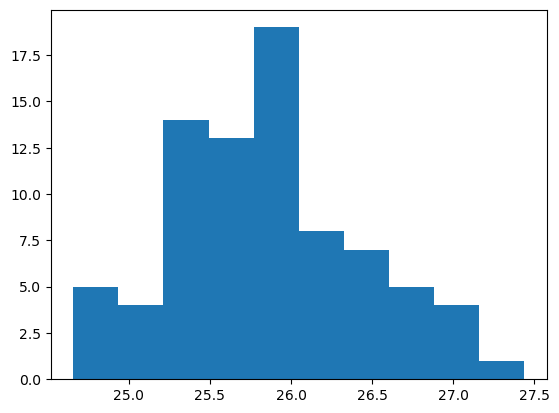

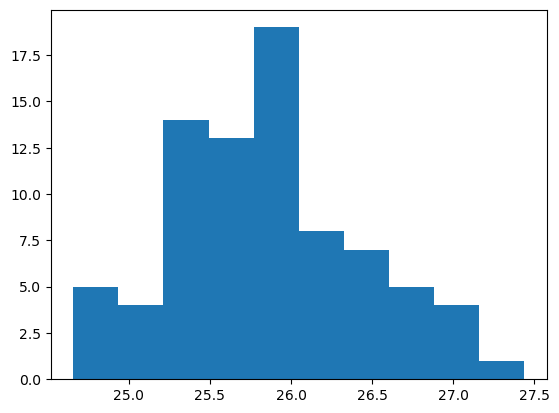

In [50]:
print(mod[0].data)
print(new_mod[0].data)
print(alt_mod[:,0,:].data.flatten())

plt.hist(mod[0].data)
plt.show()

plt.hist(new_mod[0].data)
plt.show()

plt.hist(alt_mod[:,0,:].data.flatten())
plt.show()

## 2. Run fidelity test

In [25]:
obs_stats_dict, model_stats_dict = calcDistrStatistic(obs.data, mod.data, ['mean', 'std', 'skew', 'kurt', 'linear_trend'], 10000)

In [51]:
stats_measures=timeseries_fid_test(obs,mod)

new_stats_measures=timeseries_fid_test(obs,new_mod)

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.0
Standard deviation perc: 52.769999999999996
Skewness perc: 29.21
Kurtosis perc: 10.17
Linear trend perc: 96.49
Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.0
Standard deviation perc: 41.43
Skewness perc: 32.53
Kurtosis perc: 15.67
Linear trend perc: 85.84


plotting


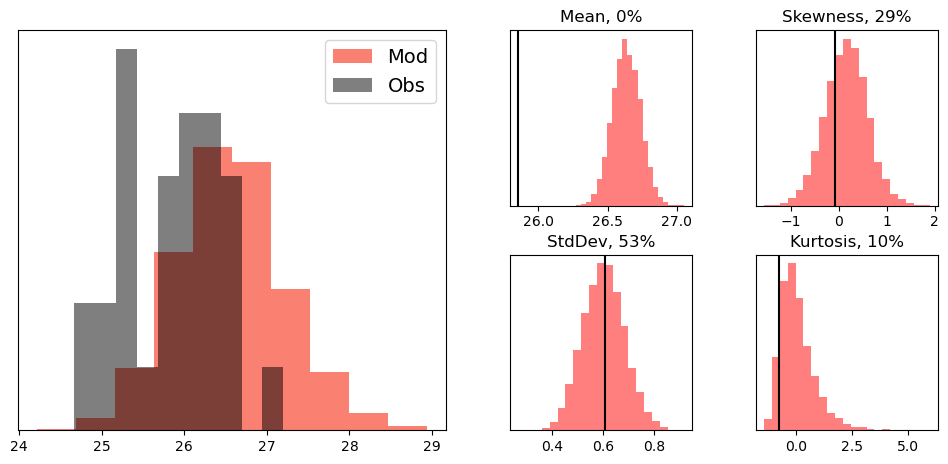

plotting


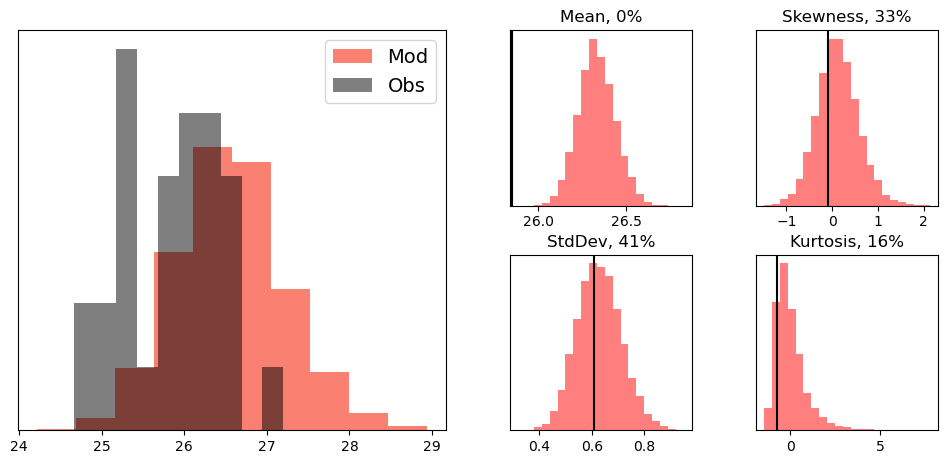

In [52]:
plot_fidelity_testing(obs, mod, stats_measures, 0.1,"fidelity test","1.png")

plot_fidelity_testing(obs, new_mod, new_stats_measures, 0.1,"fidelity test","2.png")

## 3. Bias correction
* 1) mean bias ratio method: bias correction (not ideal)
* 2) quantile mapping: needs to do moments test? how to do it after the mod data is flatted???

In [53]:
def mean_bias_correction(obs, model):
    """
    Perform mean bias correction on the model data.
    
    Parameters:
    obs (np.array): Observed values, shape (n_months,)
    model (np.array): Model forecast values, shape (n_ensembles, n_months)
    
    Returns:
    np.array: Bias-corrected model values, same shape as input model
    """
    # Calculate the mean across all ensembles and months
    model_mean = np.mean(model)
    obs_mean = np.mean(obs)
    
    # Calculate the correction factor
    correction_factor = obs_mean / model_mean
    
    # Apply the correction factor to the model data
    model_biascor = model * correction_factor
    
    return model_biascor

In [56]:
# bias correction
model_biascor= mean_bias_correction(t2m, model)
# correction factor
print(f'Mean correction factor: {np.mean(t2m)/np.mean(model)}')

new_model_biascor= mean_bias_correction(t2m, new_model)


Mean correction factor: 0.9734250674608993


In [57]:
print(obs.data)
print(model_biascor)
print(new_model_biascor)

[25.46136233 24.91844687 25.33658792 25.72635202 25.33295977 24.88123428
 26.11111837 24.66298218 25.70232735 25.39995742 25.19584727 26.49203805
 25.19621114 26.17603982 26.24247187 26.60454417 25.85328299 26.3934108
 26.11560687 26.1735169  26.03848903 27.20165105 25.39330886 25.06031059
 26.25409279 25.89774502 26.3134782  26.3660171  26.44564594 26.62519285]
[[25.70871438 24.59570939 25.23157171 ... 24.97054176 25.95847648
  25.83395142]
 [25.54012298 25.27108817 26.04127754 ... 25.41775751 25.88976414
  25.87137414]
 [25.58780016 25.49661749 25.42535128 ... 26.33840333 25.51830785
  26.17847912]
 ...
 [26.13784735 25.96569911 25.69169954 ... 25.57639131 25.88781731
  26.50293238]
 [25.6708068  26.33973402 25.32402654 ... 25.33653696 25.37742049
  26.45403472]
 [26.81339029 25.90223372 26.57751869 ... 25.23146639 25.81275157
  26.51563409]]
[[25.70871438 24.59570939 25.23157171 ... 24.68517104 24.53074337
  24.64985696]
 [25.12174611 25.53091886 25.226009   ... 25.14141729 25.52164

In [61]:
stats_measures=timeseries_fid_test(obs, model_biascor)
stats_measures=timeseries_fid_test(obs.data, model_biascor)
new_stats_measures=timeseries_fid_test(obs.data,new_model_biascor)


Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 22.35
Standard deviation perc: 61.27
Skewness perc: 28.83
Kurtosis perc: 10.43
Linear trend perc: 96.85000000000001
Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 21.69
Standard deviation perc: 61.040000000000006
Skewness perc: 29.24
Kurtosis perc: 11.01
Linear trend perc: 97.18
Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 98.56
Standard deviation perc: 49.980000000000004
Skewness perc: 32.72
Kurtosis perc: 15.85
Linear trend perc: 87.52


plotting


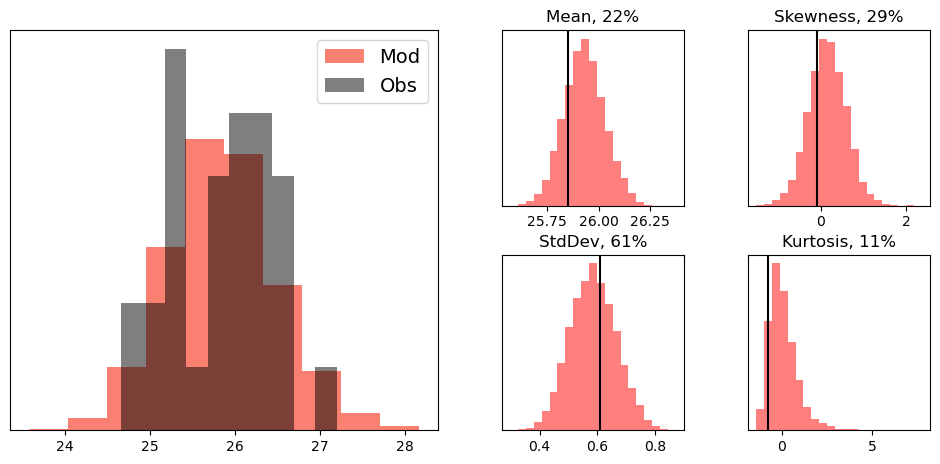

plotting


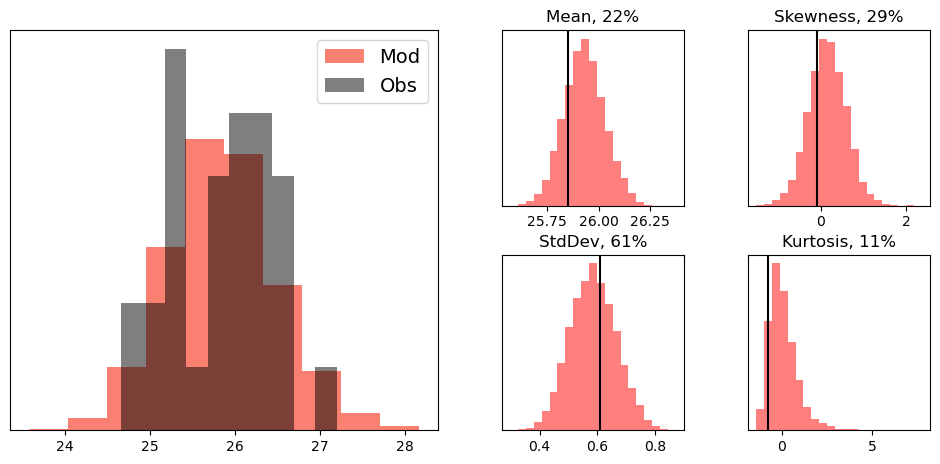

plotting


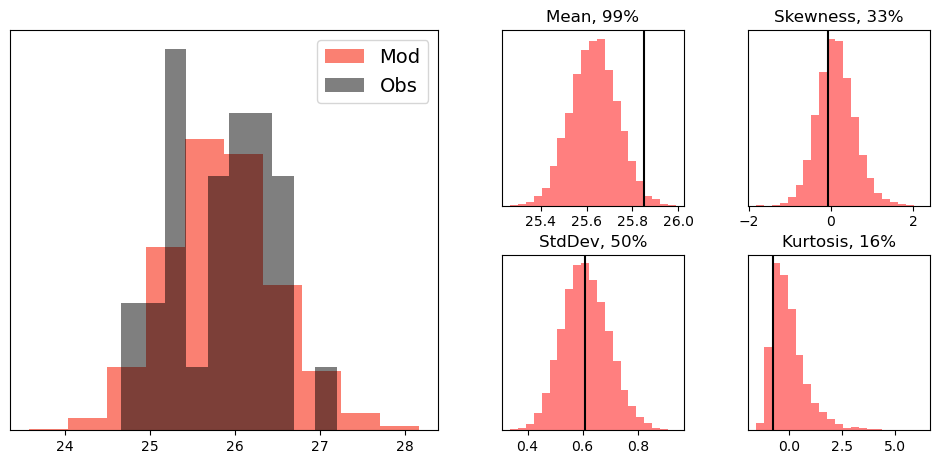

In [62]:
# after bias correction
plot_fidelity_testing(obs, model_biascor, stats_measures, 0.1,"bias correction","2.png")
plot_fidelity_testing(obs.data, model_biascor, stats_measures, 0.1,"bias correction","2.png")
plot_fidelity_testing(obs.data, new_model_biascor, new_stats_measures, 0.1,"bias correction","2.png")

In [63]:
def plot_temperature_comparison(mod, mod_cor, start_year=1992, end_year=2022):
    """
    Input args:
    mod (iris.cube.Cube): simulations
    mod_cor (iris.cube.Cube): simulations after bias correction
    start_year (int): 1992
    end_year (int): 2022
    """
    years = range(start_year, end_year)
    fig, ax = plt.subplots(figsize=(12, 6))    
#    ax.plot(years, obs, marker='s', label='Observation', color='red', linewidth=2)
    mean1 = mod.data.mean(axis=1) if mod.data.ndim > 1 else mod.data
    std1 = mod.data.std(axis=1) if mod.data.ndim > 1 else np.zeros_like(mean1)
    ax.plot(years, mean1, marker='o', label='Simulation Mean', color='blue')
    ax.fill_between(years, mean1 - std1, mean1 + std1, alpha=0.2, color='blue', label='Simulation ±1 Std Dev')
    
    mean2 = mod_cor.data.mean(axis=1) if mod_cor.data.ndim > 1 else mod_cor.data
    std2 = mod_cor.data.std(axis=1) if mod_cor.data.ndim > 1 else np.zeros_like(mean2)
    ax.plot(years, mean2, marker='s', label='Simulations_biascor Mean', color='red')
    ax.fill_between(years, mean2 - std2, mean2 + std2, alpha=0.2, color='red', label='Simulations_biascor ±1 Std Dev')
    ax.set_title(f'Temperature Comparison: Simulations vs Simulations_biascor ({start_year}-{end_year})')
    ax.set_xlabel('Year')
    ax.set_ylabel('Temperature')
    ax.set_xticks(range(start_year, end_year + 1, 5))
    ax.grid(True, linestyle='-', alpha=0.7)
    ax.legend()
    plt.show()



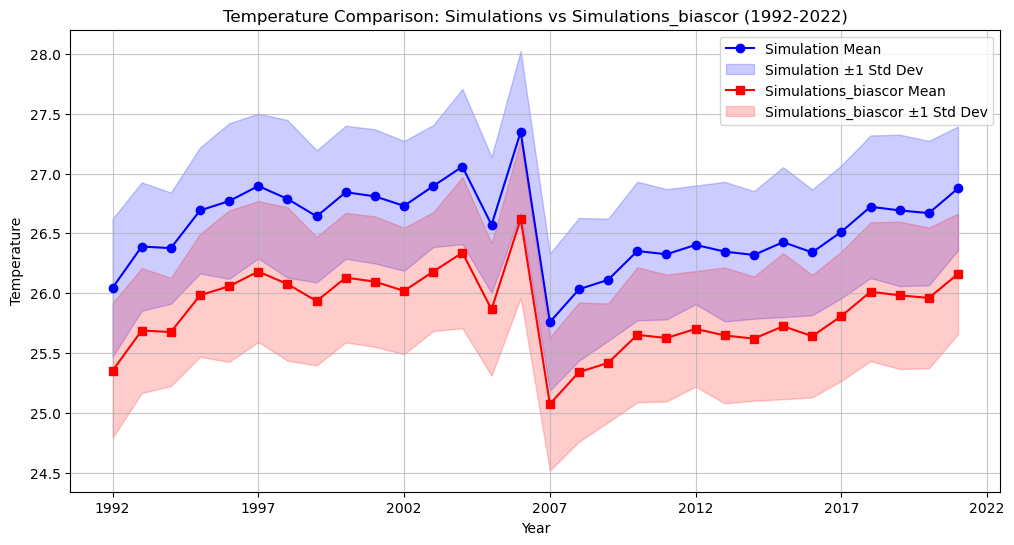

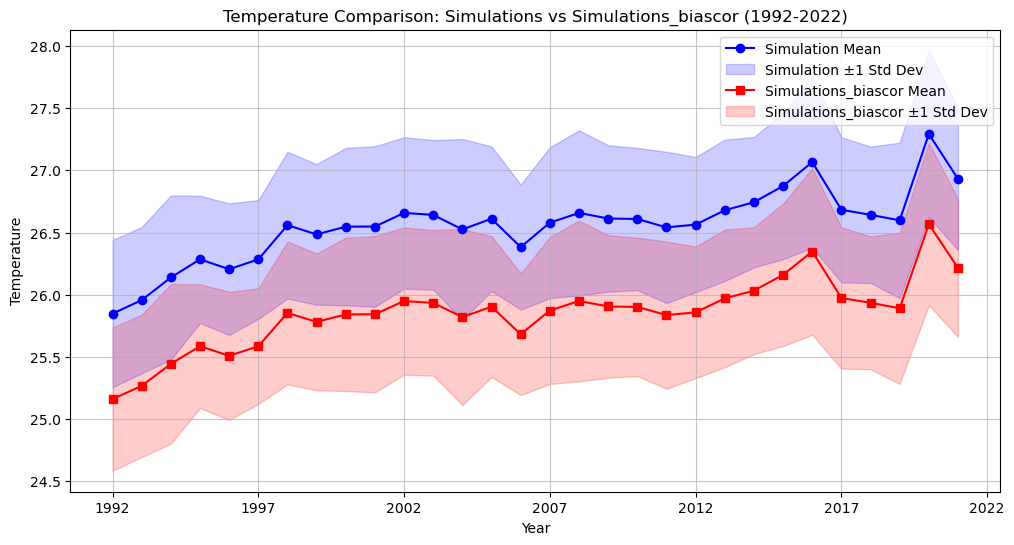

In [65]:
plot_temperature_comparison(mod,model_biascor)
plot_temperature_comparison(new_mod,new_model_biascor)

In [67]:
# quantile mapping method
mod_data = mod.data
new_mod_data = new_mod.data  
obs_data = obs.data  

def calculate_return_periods(data):
    sorted_data = np.sort(data)[::-1]
    ranks = np.arange(1, len(data) + 1)
    return_periods = (len(data) + 1) / ranks
    return sorted_data, return_periods

obs_sorted, obs_return_periods = calculate_return_periods(obs_data)
unseen_flat = mod_data.flatten()  # flatten: 2400
unseen_sorted, unseen_return_periods = calculate_return_periods(unseen_flat)
new_unseen_flat = new_mod_data.flatten()  # flatten: 2400
new_unseen_sorted, new_unseen_return_periods = calculate_return_periods(new_unseen_flat)

# gev fit
gev_params = gev.fit(obs_data) #get parameters 
return_periods = np.logspace(0, np.log10(30*80), 100)
gev_quantiles = gev.ppf(1 - 1/return_periods, *gev_params)

# Qmap
def qmap(obs, mod):
    obs_sorted = np.sort(obs)
    mod_sorted = np.sort(mod)
    obs_quantiles = np.linspace(0, 1, len(obs_sorted)) 
    mod_quantiles = np.linspace(0, 1, len(mod_sorted))
    return np.interp(mod_quantiles, obs_quantiles, obs_sorted)

unseen_qmap = qmap(obs_data, unseen_flat)
unseen_qmap_sorted, unseen_qmap_return_periods = calculate_return_periods(unseen_qmap)

new_unseen_qmap = qmap(obs_data, new_unseen_flat)
new_unseen_qmap_sorted, new_unseen_qmap_return_periods = calculate_return_periods(new_unseen_qmap)

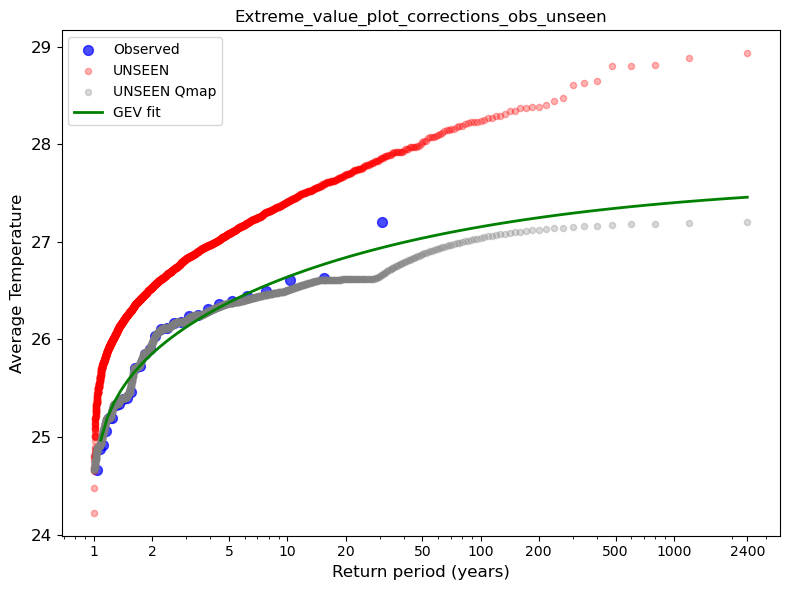

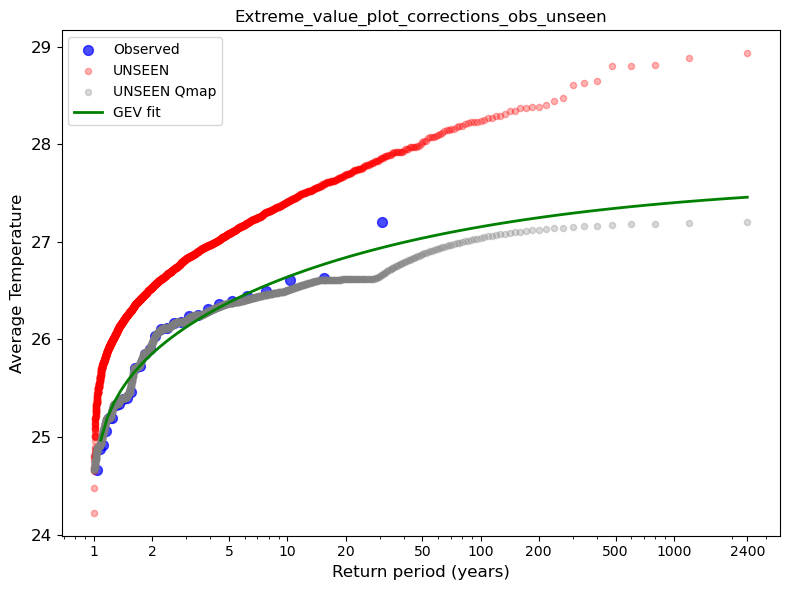

In [68]:
#plot 
plt.figure(figsize=(8, 6))
plt.scatter(obs_return_periods, obs_sorted, label='Observed', color='blue', alpha=0.7, s=50)
plt.scatter(unseen_return_periods, unseen_sorted, label='UNSEEN', color='red', alpha=0.3, s=20)
plt.scatter(unseen_qmap_return_periods, unseen_qmap_sorted, label='UNSEEN Qmap', color='grey', alpha=0.3, s=20)
plt.plot(return_periods, gev_quantiles, label='GEV fit', color='green', linewidth=2)
plt.xscale('log')
plt.xlabel('Return period (years)', fontsize=12)
plt.ylabel('Average Temperature', fontsize=12)
plt.title('Extreme_value_plot_corrections_obs_unseen', fontsize=12)
x_ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000,2400]
plt.xticks(x_ticks, x_ticks, fontsize=10)
plt.legend(fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

#plot 
plt.figure(figsize=(8, 6))
plt.scatter(obs_return_periods, obs_sorted, label='Observed', color='blue', alpha=0.7, s=50)
plt.scatter(new_unseen_return_periods, new_unseen_sorted, label='UNSEEN', color='red', alpha=0.3, s=20)
plt.scatter(new_unseen_qmap_return_periods, new_unseen_qmap_sorted, label='UNSEEN Qmap', color='grey', alpha=0.3, s=20)
plt.plot(return_periods, gev_quantiles, label='GEV fit', color='green', linewidth=2)
plt.xscale('log')
plt.xlabel('Return period (years)', fontsize=12)
plt.ylabel('Average Temperature', fontsize=12)
plt.title('Extreme_value_plot_corrections_obs_unseen', fontsize=12)
x_ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000,2400]
plt.xticks(x_ticks, x_ticks, fontsize=10)
plt.legend(fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()